<a href="https://colab.research.google.com/github/jatyrAR/Computational_statistique/blob/master/EMAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1>EM Algorithm for a Gaussian Mixture Model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import multivariate_normal
from scipy.cluster.vq import kmeans

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data generation

In [0]:
p = np.array([1/4,1/4,1/2])
z = np.zeros(1000).astype(int)
for i in range(1000):
  u = np.random.uniform()
  if (u<p[0]) : z[i] = 0
  elif (u<p[1]+p[0]) : z[i]=1
  else : z[i]=2

In [0]:
sigma0=np.array([[1,-1],[-1,3]])
mu0=np.zeros(2)
sigma1=np.array([[3,-3],[-3,9]])
mu1=np.array([10,10])
sigma2=np.array([[7,-1],[-1,2]])
mu2=np.array([-10,-10])

In [0]:
x0 = np.random.multivariate_normal(mean=mu0, cov=sigma0, size=1000)
x1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=1000)
x2 = np.random.multivariate_normal(mean=mu2, cov=sigma2, size=1000)

In [0]:
x=np.array([[0,0]]*1000).astype(float)
for i in range(1000):
  x[i] = eval(f'x{z[i]}[{i}]')

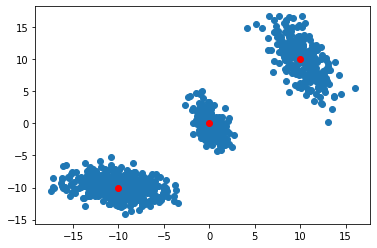

In [0]:
plt.scatter(x[:,0],x[:,1])
plt.scatter(mu0[0],mu0[1],color = 'r')
plt.scatter(mu1[0],mu1[1],color = 'r')
plt.scatter(mu2[0],mu2[1],color = 'r')

#EM Algorithm

In [0]:
class EM():

  def __init__(self,data,k,pi,means,sigmas):
    '''
    data : les point x
    k : le nombre de cluster/gaussiennes
    pi : la distrubition initiale pour les variables lattente, tableau de taille k contenat p0,p1,...,pk
    means : les k moyennes de chacune de nos gaussienne
    sigmas : les k matrice de covarience
    '''
    self.data=data
    self.k=k
    self.pi=pi
    self.means=means
    self.sigmas=sigmas

  def E_step(self):
    '''
    Donne Gamma_k,i qui est le proba que zi=k par rapport a notre estimation courantes des parametres des gaussiennes  
    '''
    gammas = np.zeros((self.k,self.data.shape[0]))
    for j in range(self.k):
      gammas[j]=multivariate_normal.pdf(x=self.data,mean=self.means[j],cov=self.sigmas[j])*self.pi[j]
    normalisation = gammas.sum(axis=0)
    gammas=gammas/normalisation
    return gammas

  def M_step(self,gammas):
    '''
    gammas = le tableau des gammas, c'est un tableau de taille k*len(data) avec gamma_ki=p(zi=k|xi)
    modifie les parametre de nos gaussiennes 
    '''
    self.pi = gammas.sum(axis=1)/self.data.shape[0]
    for j in range(self.k):
      self.means[j]= (np.array([gammas[j,:],gammas[j,:]]).T*self.data).sum(axis=0)/gammas[j,:].sum()
      self.sigmas[j]=(np.array([gammas[j,:],gammas[j,:]]).T*(self.data-self.means[j])).T@(self.data-self.means[j])/gammas[j,:].sum()

  def __call__(self,steps):
    '''
    run the EM algorithm for steps itteration.
    '''
    for i in range(steps):
      gammas = self.E_step()
      self.M_step(gammas)
    print(f'successfully ran {steps} steps of the EM algorthm !')
    print(f'the esimated wieigths of the classes are: {self.pi}')
    print(f'the esimated means of the classes are: {self.means}')
    print(f'the esimated covariances of the classes are: {self.sigmas}')

  def show_result(self):
    '''
    print les données observees et les ligne de niveaux des gaussiennes 
    '''
    xmin,xmax = self.data[:,0].min(),self.data[:,0].max()
    ymin,ymax = self.data[:,1].min(),self.data[:,1].max()
    x=np.linspace(xmin,xmax,1000)
    y=np.linspace(ymin,ymax,1000)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((1000,1000))
    for i in range(1000):
      for j in range(self.k):
        Z[i]+=multivariate_normal.pdf(x=np.array([X[i],Y[i]]).T,mean=self.means[j],cov=self.sigmas[j])*self.pi[j]
    fig, ax = plt.subplots()
    ax.scatter(self.data[:,0],self.data[:,1])
    for j in range(self.k) : ax.scatter(self.means[j,0],self.means[j,1],color='r')
    CS = ax.contour(X, Y, Z)


#Resultats

In [0]:
means=np.array([np.zeros(2)]*3)
sigmas=np.array([np.eye(2),np.eye(2),np.eye(2)])
p=np.array([0.3,0.3,0.4])

In [0]:
expl1=EM(x,3,p,means,sigmas)

In [0]:
expl1(10000)

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.25509269 0.25509269 0.48981462]
the esimated means of the classes are: [[  4.76316972   4.56015985]
 [  4.76316972   4.56015985]
 [-10.06878697  -9.96250768]]
the esimated covariances of the classes are: [[[29.55310909 25.37132376]
  [25.37132376 34.43020095]]

 [[29.55310909 25.37132376]
  [25.37132376 34.43020095]]

 [[ 6.8241913  -0.92342345]
  [-0.92342345  1.99221726]]]


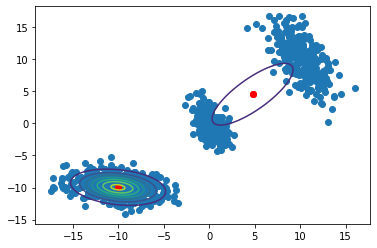

In [0]:
expl1.show_result()

L'algorithme est sensible a l'initialisation. Le mieux est de commencer par un kmeans pour trouver les moyennes initiales. C'est ce qu'on fait dans la suite

In [0]:
means = kmeans(expl1.data,3)[0]

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.259 0.498 0.243]
the esimated means of the classes are: [[  0.09775364  -0.07264192]
 [-10.03035927  -9.94994491]
 [ 10.15663057   9.96144776]]
the esimated covariances of the classes are: [[[ 0.91431498 -0.93326502]
  [-0.93326502  3.16902294]]

 [[ 6.89054462 -0.89218247]
  [-0.89218247  2.03288854]]

 [[ 3.34143645 -3.67020714]
  [-3.67020714 10.35219374]]]


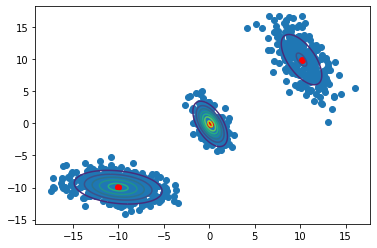

In [0]:
expl2=EM(x,3,p,means,sigmas)
expl2(10000)
expl2.show_result()

Si on initialise avec un k means cela fonctionne mieux ! les moyennes, poids et matrices de covariances sont assez proche de celle que j'ai choisi pour simuler les données.

In [0]:
means = kmeans(expl1.data,4)[0]
sigmas = np.array([np.eye(2)]*4)
pi=np.array([0.25,0.25,0.25,0.25])

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.48375969 0.243      0.259      0.01424031]
the esimated means of the classes are: [[ -9.8868878   -9.9930385 ]
 [ 10.15663057   9.96144776]
 [  0.09775364  -0.07264192]
 [-14.90425123  -8.48600583]]
the esimated covariances of the classes are: [[[ 6.27403775 -0.77259135]
  [-0.77259135  1.96421447]]

 [[ 3.34143645 -3.67020714]
  [-3.67020714 10.35219374]]

 [[ 0.91431498 -0.93326502]
  [-0.93326502  3.16902294]]

 [[ 3.37990916  2.39028313]
  [ 2.39028313  2.15962215]]]


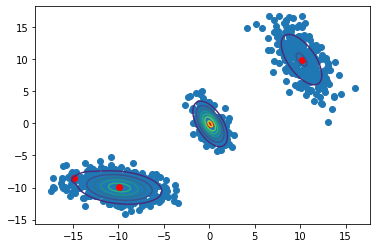

In [0]:
expl2=EM(x,4,pi,means,sigmas)
expl2(10000)
expl2.show_result()

Lorsqu'on parametrise le tout avec trop de gaussiennes le resultat semble tout de même satisfaisant

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.48981462 0.51018538]
the esimated means of the classes are: [[-10.06878697  -9.96250768]
 [  4.76316972   4.56015985]]
the esimated covariances of the classes are: [[[ 6.8241913  -0.92342345]
  [-0.92342345  1.99221726]]

 [[29.55310909 25.37132376]
  [25.37132376 34.43020095]]]


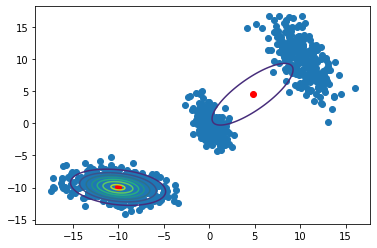

In [0]:
means = kmeans(expl1.data,2)[0]
sigmas = np.array([np.eye(2)]*2)
pi=np.array([0.5,0.5])
means.shape,sigmas.shape
expl2=EM(x,2,pi,means,sigmas)
expl2(10000)
expl2.show_result()

Bien sur si on ne parametrise pas assez de classe les resultats sont mauvais.

# Application aux données : Crude birth and death rate

In [0]:
path = Path('drive/My Drive/data_birth.csv')

In [0]:
data = pd.read_csv(path, header=0, na_filter=True)
data.dropna(inplace=True)
data[0:5]

,Unnamed: 0,Crude birth rate (per 1000 population),Crude death rate (per 1000 population)
0,Country,2013.0,2013.0
1,Afghanistan,34.1,7.7
2,Albania,12.9,9.4
3,Algeria,24.3,5.7
4,Andorra,8.9,8.4


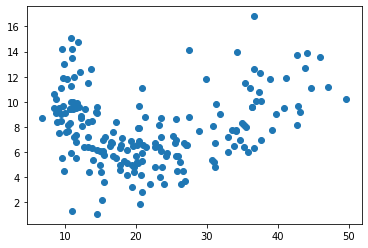

In [0]:
plt.scatter(x[:,0],x[:,1])

In [0]:
def EM_algo(x,k):
  means = kmeans(x,k)[0]
  sigmas = np.array([np.eye(2)]*k)
  pi=np.array(1/k*np.ones(k))
  expl2=EM(x,k,pi,means,sigmas)
  expl2(10000)
  expl2.show_result()

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [1.]
the esimated means of the classes are: [[21.72746114  7.8865285 ]]
the esimated covariances of the classes are: [[[109.0339091    4.25254611]
  [  4.25254611   8.25038847]]]


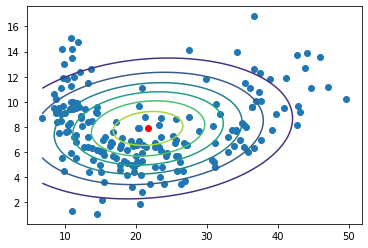

In [0]:
EM_algo(x,1)

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.32635684 0.67364316]
the esimated means of the classes are: [[11.43821549  9.24400677]
 [26.7122453   7.22887715]]
the esimated covariances of the classes are: [[[ 4.19364741 -1.54468611]
  [-1.54468611  5.89857704]]

 [[83.68765317 17.10609111]
  [17.10609111  8.06450718]]]


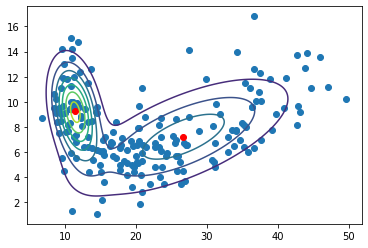

In [0]:
EM_algo(x,2)

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.45205326 0.2689672  0.27897953]
the esimated means of the classes are: [[19.81159839  5.90045429]
 [36.16410284  9.39159464]
 [10.91336624  9.65367565]]
the esimated covariances of the classes are: [[[20.75819786  0.46996518]
  [ 0.46996518  3.13411937]]

 [[31.84897141  6.86335498]
  [ 6.86335498  7.58287958]]

 [[ 2.66003004 -0.13916563]
  [-0.13916563  5.48593267]]]


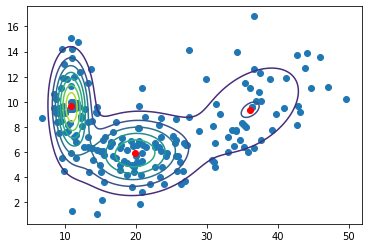

In [0]:
EM_algo(x,3)

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.2772405  0.37896357 0.25551668 0.08827926]
the esimated means of the classes are: [[10.91233927  9.6943521 ]
 [19.60834121  5.93213125]
 [36.23918962  8.82600086]
 [22.78626448  7.87964792]]
the esimated covariances of the classes are: [[[ 2.67749281 -0.08823921]
  [-0.08823921  5.26524507]]

 [[19.26827127 -0.88442195]
  [-0.88442195  2.12390404]]

 [[33.51442118 10.22433819]
  [10.22433819  6.43753647]]

 [[49.70693678 26.8219077 ]
  [26.8219077  19.95648788]]]


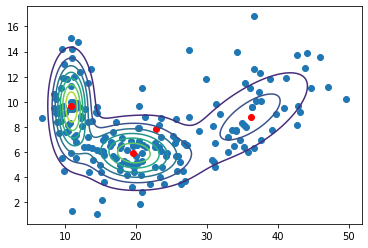

In [0]:
EM_algo(x,4)

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.10496991 0.14891304 0.04020837 0.2875114  0.41839729]
the esimated means of the classes are: [[34.0779126   7.15317665]
 [38.88225923 11.22886422]
 [26.07058578  5.27283713]
 [10.96025242  9.60603157]
 [19.50485224  5.95051703]]
the esimated covariances of the classes are: [[[ 5.74106636  1.30166781]
  [ 1.30166781  1.6515968 ]]

 [[28.556839   -0.34755417]
  [-0.34755417  4.55936729]]

 [[ 0.26317937 -0.54765017]
  [-0.54765017  1.53876491]]

 [[ 2.77904404 -0.2148045 ]
  [-0.2148045   5.3936471 ]]

 [[17.63217001  1.53697013]
  [ 1.53697013  3.28037576]]]


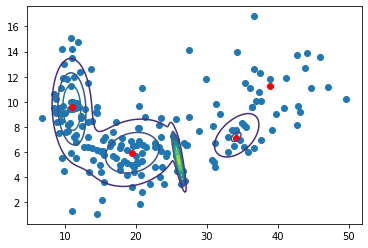

In [0]:
EM_algo(x,5)

successfully ran 10000 steps of the EM algorthm !
the esimated wieigths of the classes are: [0.15386319 0.07994344 0.24972593 0.11110165 0.14590974 0.25945605]
the esimated means of the classes are: [[24.86128538  6.04382997]
 [20.43775972  6.39565804]
 [16.15617631  6.05581054]
 [34.01813158  7.19199304]
 [38.97852779 11.27558382]
 [10.66433425  9.5922293 ]]
the esimated covariances of the classes are: [[[ 3.41744227  0.18137776]
  [ 0.18137776  2.31078814]]

 [[ 0.2609675   0.33197374]
  [ 0.33197374  5.0682909 ]]

 [[ 7.23637498 -1.68155043]
  [-1.68155043  3.29538984]]

 [[ 6.08098316  1.37759123]
  [ 1.37759123  1.77836443]]

 [[28.14807507 -0.58007926]
  [-0.58007926  4.51247619]]

 [[ 2.08448465  0.19730271]
  [ 0.19730271  6.89632717]]]


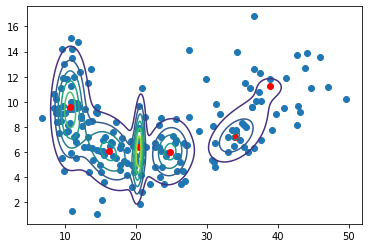

In [0]:
EM_algo(x,6)

Les meilleurs résultats sont lorsqu'on selectionne deux ou trois catégories de pays différents.